# Plotting Audio Samples

Use this notebook to plot waveforms and spectrograms of the obtained audio samples from training and evaluation.

In [25]:
import os
import torchaudio
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from scipy import fft, signal

# plt.style.use('ggplot')
# plt.rcParams['figure.dpi'] = 150            # Set figure quality
# plt.rcParams['figure.figsize'] = (6, 4)     # Set default figure size

# plt.rcParams['lines.linewidth'] = 0.6     # Set the default linewidth  
plt.rcParams['axes.grid'] = True           # Enable grid lines
plt.rcParams['font.size'] = 8             # Set the default linewidth

# %matplotlib inline
# mpl.rcParams.keys()                       # List all the parameters
# mpl.rcParams.update(mpl.rcParamsDefault)  # Restore defaults

In [26]:
TRAIN_SAMPLES = "../audio/train"
EVAL_SAMPLES = "../audio/eval"
PLOTS_DIR = "../docs/assets/plots/eval/"

start_idx = 0.06
end_idx = 0.08

In [27]:
def check_dc_offset(pred, target):
    pred_offset = pred.mean()
    target_offset = target.mean()
    dc_offset = pred_offset - target_offset

    # Smallest quantization step for 16-bit audio
    quantization_step_16bit = 1 / 32767.0

    # Check if the absolute value of the DC offset is smaller or larger than the quantization step
    if abs(dc_offset) < quantization_step_16bit:
        print("The DC offset is smaller than the smallest quantization step for 16-bit audio.")
    else:
        print("The DC offset is larger than the smallest quantization step for 16-bit audio.")

In [28]:
def plot_overlap_waveforms(output, target, sample_rate, start_idx, end_idx, title):    
    """Plots the output and target waveforms overlapped."""
    
    output = output[int(sample_rate * start_idx):int(sample_rate * end_idx)]
    target = target[int(sample_rate * start_idx):int(sample_rate * end_idx)]
 
    if len(output) != len(target):
        raise ValueError(f"Output and target have different lengths after slicing: {len(output)} and {len(target)}")

    N = len(output)  # FFT size, also used for time vector calculation
    t = np.linspace(start_idx, end_idx, N, endpoint=False)  # Time vector corrected

    plt.figure()
    plt.plot(t, output, alpha=0.8, label="Model")
    plt.plot(t, target, alpha=0.8, label="Target")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

In [29]:
def plot_overlap_time_freq(output, target, sample_rate, start_idx, end_idx):

    output = output[int(sample_rate * start_idx):int(sample_rate * end_idx)]
    target = target[int(sample_rate * start_idx):int(sample_rate * end_idx)]
    
    if len(output) != len(target):
        raise ValueError(f"Output and target have different lengths after slicing: {len(output)} and {len(target)}")

    N = len(output)  # FFT size, also used for time vector calculation
    t = np.linspace(start_idx, end_idx, N, endpoint=False)  # Time vector corrected

    fs = sample_rate
    T = 1 / fs                              # sampling interval
    # t = np.arange(start_idx,end_idx, T)     # Time vector
    # N = len(output)                         # FFT size

    # Compute FFT with the window 
    w = signal.get_window('blackmanharris', N)    # Window function
    output_fft = fft.rfft(output * w) / N   # FFT normalized by the FFT size 
    target_fft = fft.rfft(target * w) / N   # FFT normalized by the FFT size
    
    output_fft = 20 * np.log10(np.abs(output_fft[:N//2]))
    target_fft = 20 * np.log10(np.abs(target_fft[:N//2]))

    xf = fft.rfftfreq(N, T)[:N//2]          # Calculate the frequencies

    fig, (ax1, ax2) = plt.subplots(figsize=(8,5), nrows=2, ncols=1)
    
    plt.sca(ax1)
    plt.plot(t,output, alpha=0.5, label='Output')
    plt.plot(t,target, alpha=0.5, label='Target')
    plt.xlim(t[0],t[-1])
    plt.ylabel('Amplitude')
    plt.xlabel('Time [s]')
    plt.legend()
    
    plt.sca(ax2)
    plt.semilogx(xf[:N//2], output_fft[:N//2], alpha=0.5,label='Output')
    plt.semilogx(xf[:N//2], target_fft[:N//2], alpha=0.5,label='Target')
    plt.xlim(50, 16000)
    plt.ylim(-80, -20)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.legend()
    
    # Set x-axis ticks
    custom_ticks = [20, 100, 1000, 10000]
    plt.xticks(custom_ticks, custom_ticks)

    plt.tight_layout()
    plt.show()

In [30]:
def plot_spectrogram_difference(output, target, sample_rate, start_idx, end_idx):
    output = output[int(sample_rate * start_idx):int(sample_rate * end_idx)]
    target = target[int(sample_rate * start_idx):int(sample_rate * end_idx)]
    
    if len(output) != len(target):
        raise ValueError(f"Output and target have different lengths after slicing: {len(output)} and {len(target)}")

    N = len(output)  # FFT size, also used for time vector calculation
    t = np.linspace(start_idx, end_idx, N, endpoint=False)  # Time vector corrected

    fs = sample_rate
    # T = 1 / fs                                  # sampling interval
    # t = np.arange(start_idx,end_idx, T)         # Time vector
    N = 256                                     # FFT size
    w = signal.get_window('blackmanharris', N)  # Window function
    hop_size = N // 4                           # Hop size

    # Compute the STFT for both signals
    Pxx_1, freqs_1, t_1, _= plt.specgram(output, NFFT=N, Fs=sample_rate, window=w, noverlap=hop_size, scale='dB', mode='magnitude')
    Pxx_2, freqs_2, t_2, _ = plt.specgram(target, NFFT=N, Fs=sample_rate, window=w, noverlap=hop_size, scale='dB', mode='magnitude')
    plt.close()

    # Convert time values to sample values considering the 'start' index
    t_o_samples = t_1 * sample_rate + start_idx  # Here's the modification
    t_t_samples = t_2 * sample_rate + start_idx  # This should give you the absolute index in terms of the original signal

    # Subtract one spectrogram from the other
    difference = 10 * np.log10(Pxx_2 + 1e-7) - 10 * np.log10(Pxx_1 + 1e-7)  # Convert to dB and then subtract

    # Plot the difference
    fig, ax = plt.subplots(figsize=(8, 3))
    img = ax.imshow(difference, aspect='auto', origin='lower', cmap='coolwarm', extent=[t_o_samples[0], t_o_samples[-1], freqs_1[0], freqs_1[-1]])
    ax.set_title("Spectrograms Difference")
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Samples')
    ax.set_ylim(0, 10000)
    ax.grid(True)

    cbar = fig.colorbar(img, ax=ax, format="%+2.0f dB")
    cbar.set_label('Intensity [dB]')

    plt.tight_layout()
    plt.show()

In [31]:
def process_directory(directory_path, start_idx, end_idx):
    """
    Walk through directory_path, and for each pair of pred_{some_model_name}.wav and targ_{same_model_name}.wav, 
    load them using torchaudio and call overlap_waveforms and two_spectrograms_difference functions.
    """
    directory_path = Path(directory_path)
    output_files = [f for f in directory_path.iterdir() if f.name.startswith("pred") and f.suffix == ".wav"]
    
    for out_file in output_files:
        # Construct the expected name for the target file by replacing "pred" with "targ"
        tgt_file_name = out_file.name.replace("pred", "target")
        tgt_file = directory_path / tgt_file_name
        
        if tgt_file.exists():
            # Load the audio files using torchaudio
            output, sample_rate = torchaudio.load(str(out_file))
            target, _ = torchaudio.load(str(tgt_file))
            
            output = output.view(-1).numpy()
            target = target.view(-1).numpy()

            # Construct the title for the plots
            title = f"Output vs. Target for {out_file.name[5:-4]}"
            print(f"Processing {out_file.name} and {tgt_file_name}")

            # Call the plotting functions
            # plot_overlap_waveform(output, target, sample_rate, start_idx, end_idx, title)
            plot_overlap_time_freq(output, target, sample_rate, start_idx, end_idx)
            # plot_spectrogram_difference(output, target, sample_rate, start_idx, end_idx)
        else:
            print(f"Matching target file for {out_file} not found!")

Processing pred-GRU-99-stft-48k.wav and target-GRU-99-stft-48k.wav


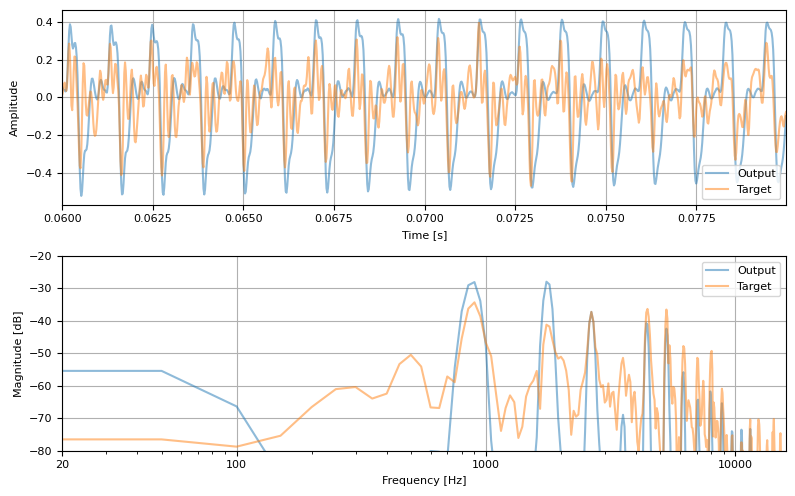

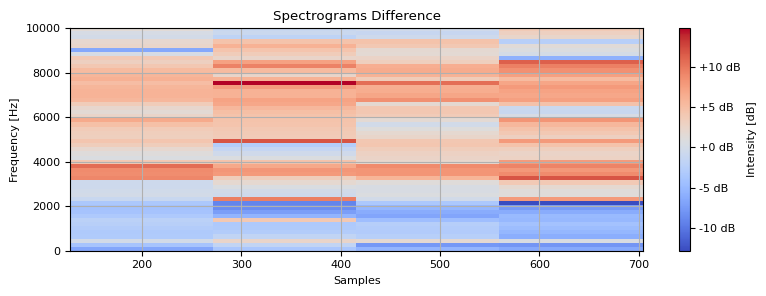

Processing pred-GCN-99-stft-48k.wav and target-GCN-99-stft-48k.wav


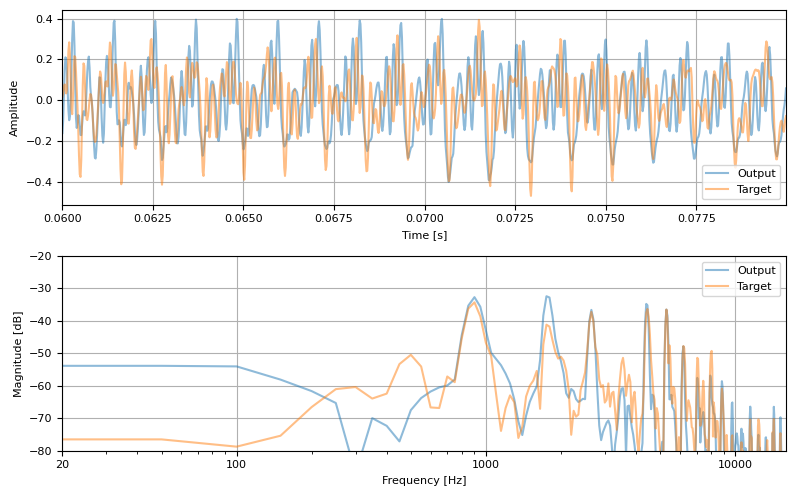

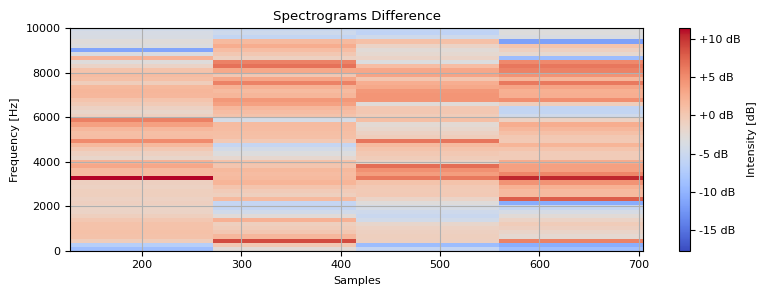

Processing pred-GCN-stft-48k.wav and target-GCN-stft-48k.wav


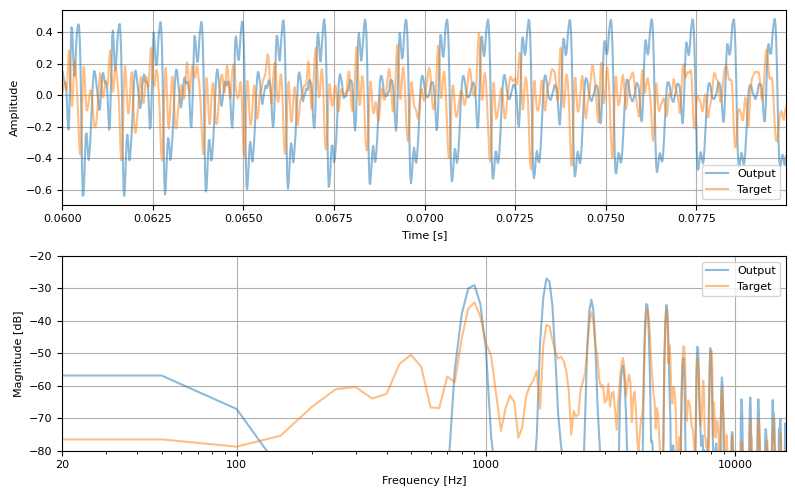

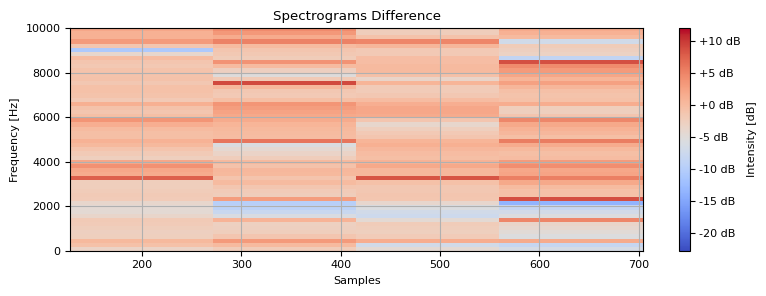

Processing pred-LSTM-stft-16k.wav and target-LSTM-stft-16k.wav


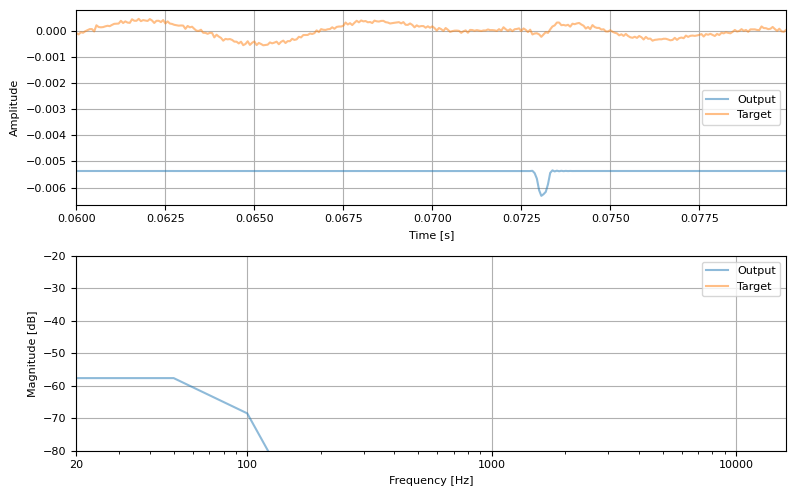

/var/folders/yq/mvb7f1jd0y7dbw4v5k8x2s_r0000gn/T/ipykernel_33215/4183684329.py:32: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  img = ax.imshow(difference, aspect='auto', origin='lower', cmap='coolwarm', extent=[t_o_samples[0], t_o_samples[-1], freqs_1[0], freqs_1[-1]])


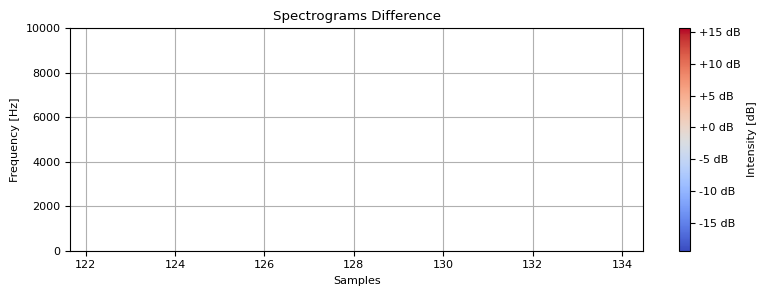

Processing pred-LSTM-99-stft-16k.wav and target-LSTM-99-stft-16k.wav


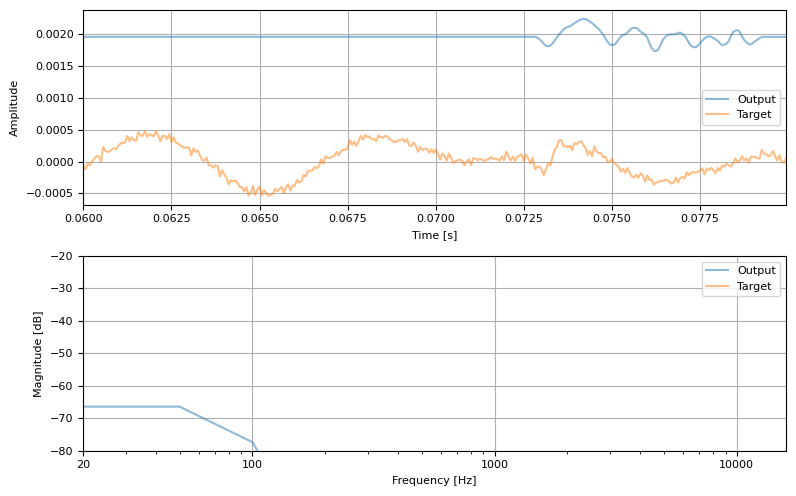

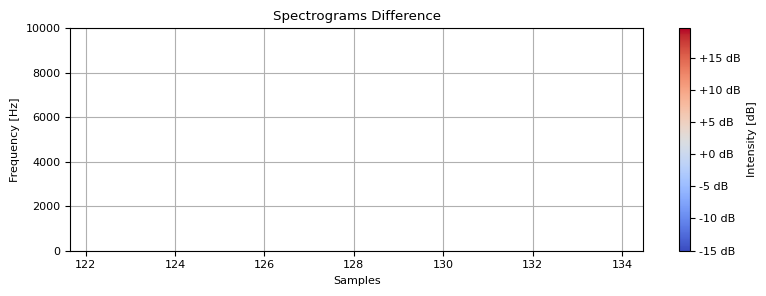

Processing pred-WaveNet-99-stft-48k.wav and target-WaveNet-99-stft-48k.wav


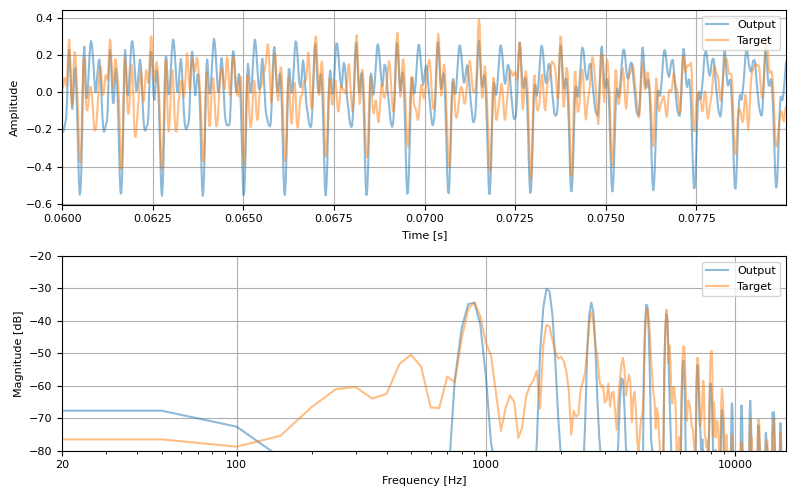

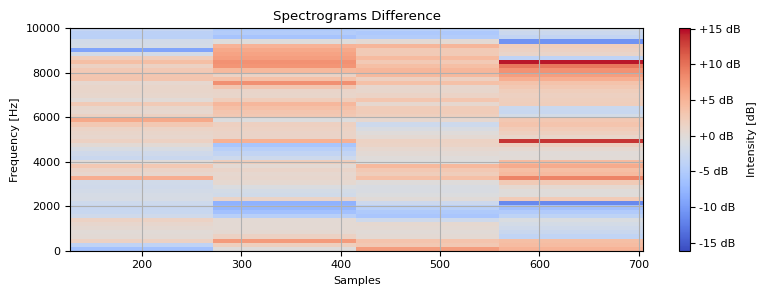

Processing pred-TCN-stft-16k.wav and target-TCN-stft-16k.wav


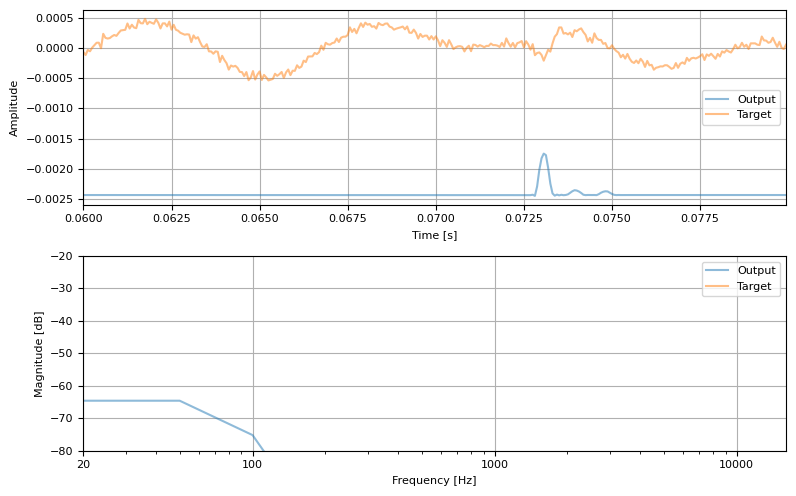

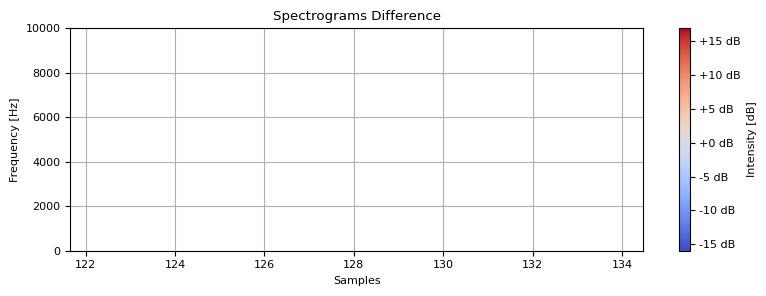

Processing pred-WaveNet-stft-16k.wav and target-WaveNet-stft-16k.wav


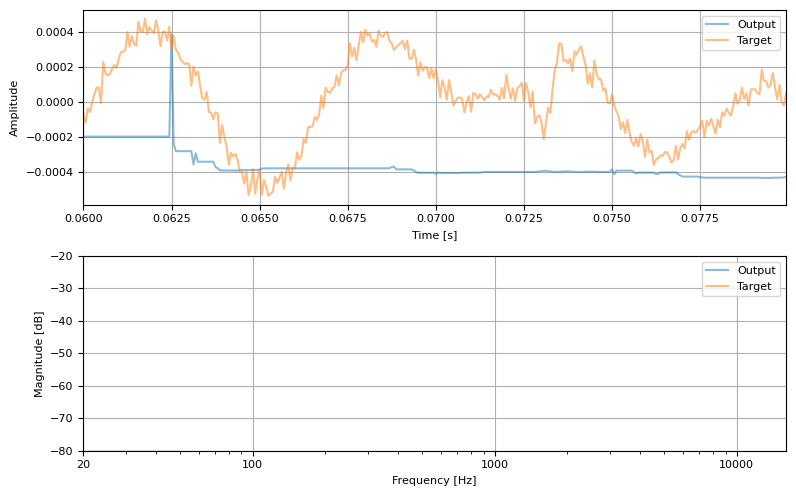

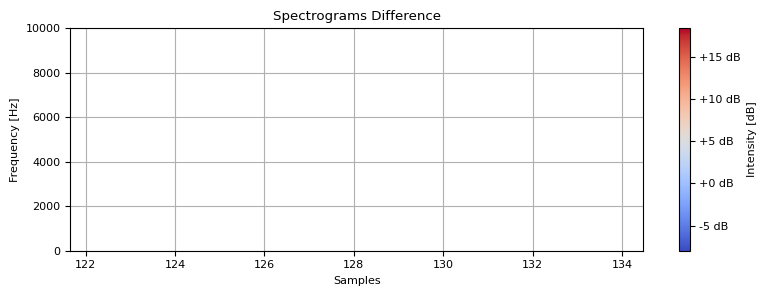

Processing pred-GRU-stft-16k.wav and target-GRU-stft-16k.wav


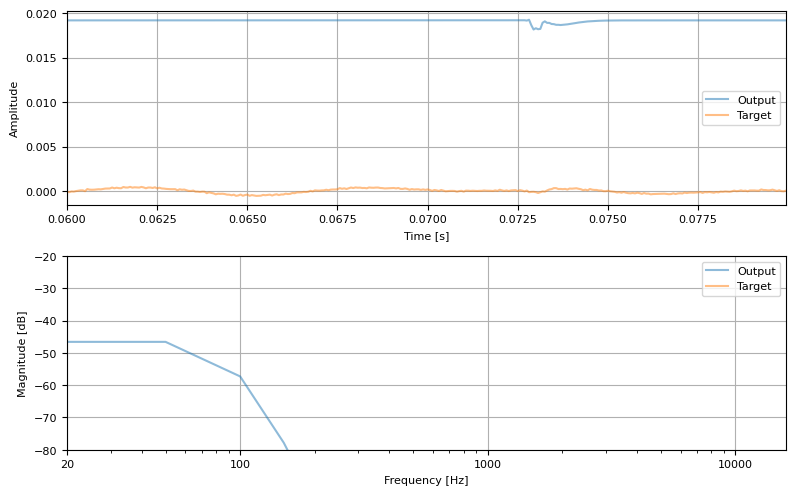

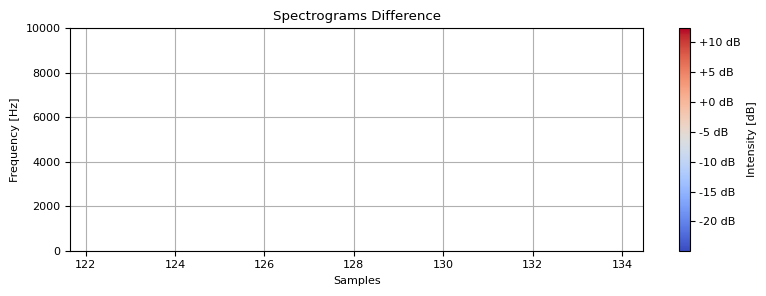

Processing pred-TCN-99-stft-16k.wav and target-TCN-99-stft-16k.wav


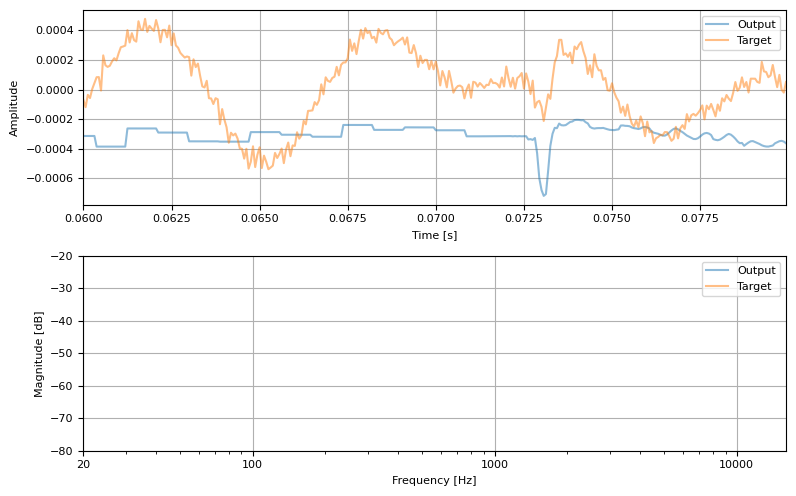

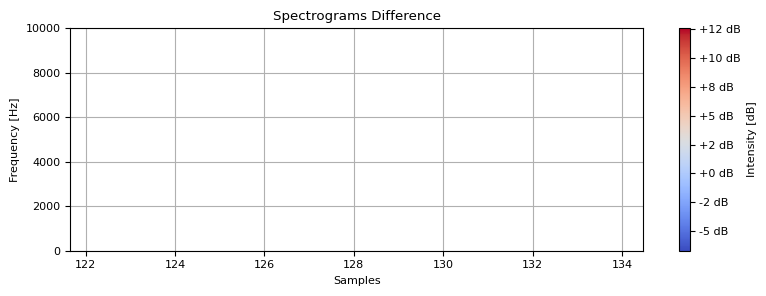

Processing pred-LSTM-99-stft-48k.wav and target-LSTM-99-stft-48k.wav


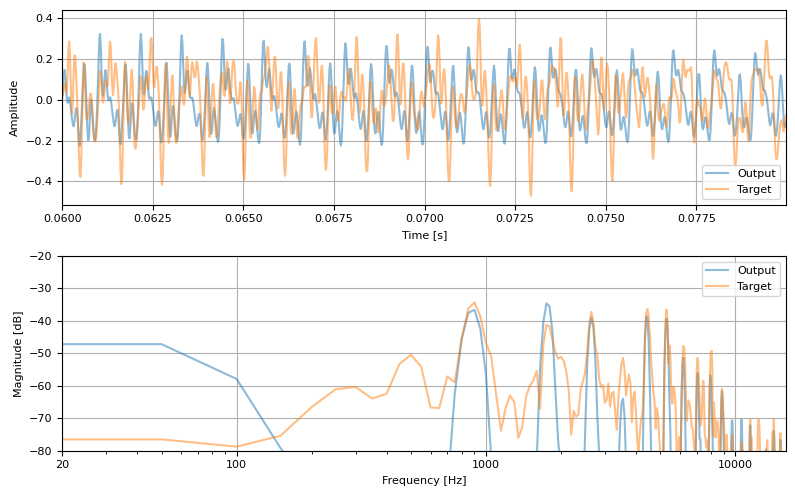

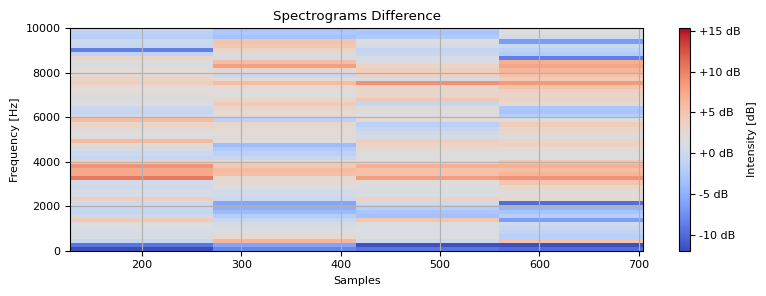

Processing pred-LSTM-stft-48k.wav and target-LSTM-stft-48k.wav


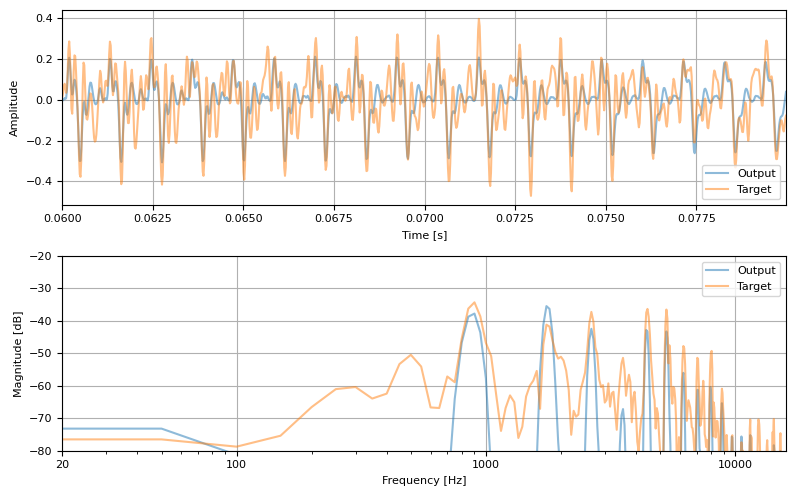

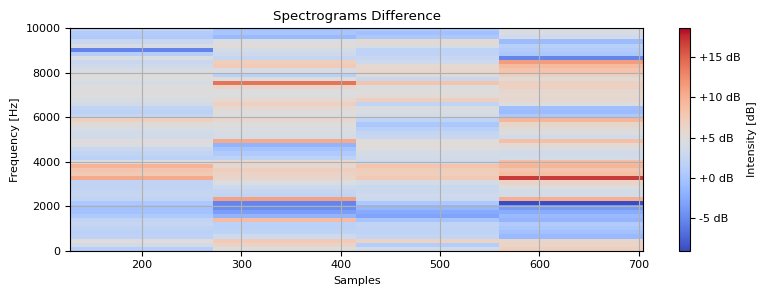

Processing pred-GCN-stft-16k.wav and target-GCN-stft-16k.wav


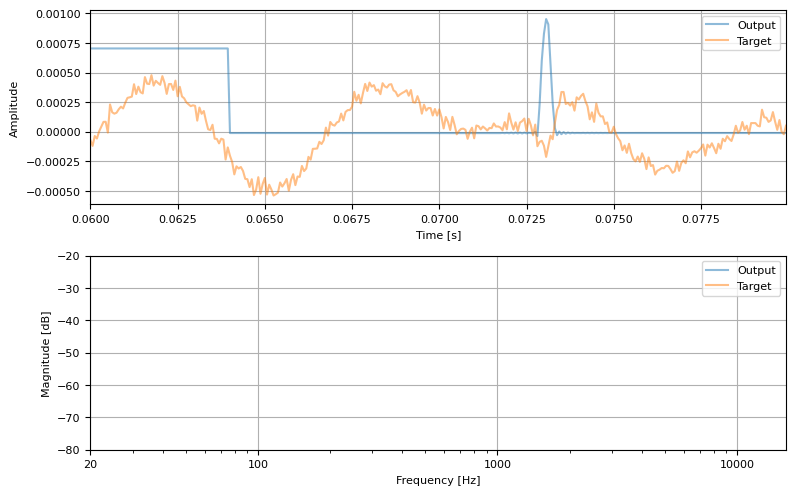

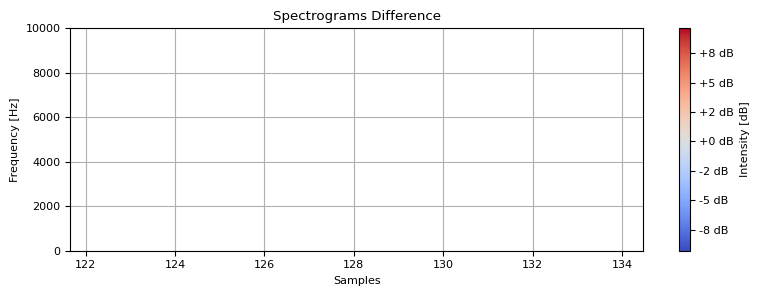

Processing pred-GCN-99-stft-16k.wav and target-GCN-99-stft-16k.wav


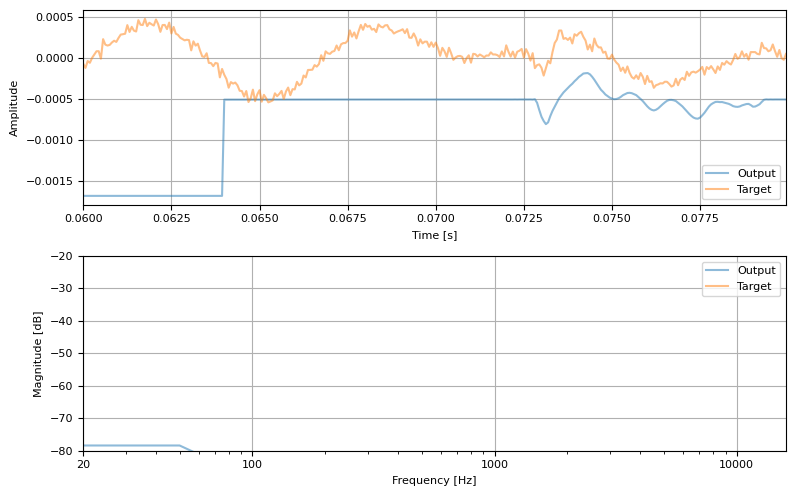

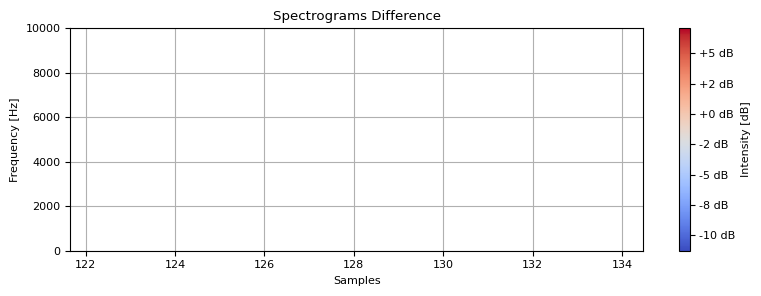

Processing pred-GRU-99-stft-16k.wav and target-GRU-99-stft-16k.wav


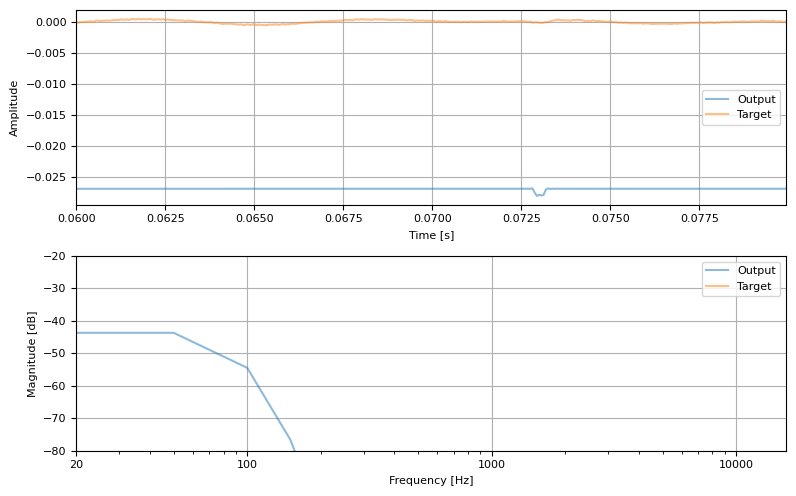

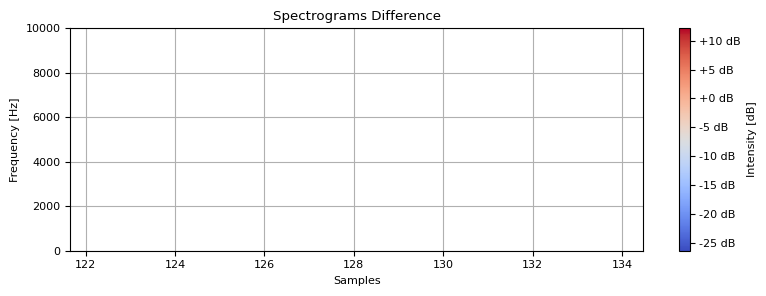

Processing pred-TCN-99-stft-48k.wav and target-TCN-99-stft-48k.wav


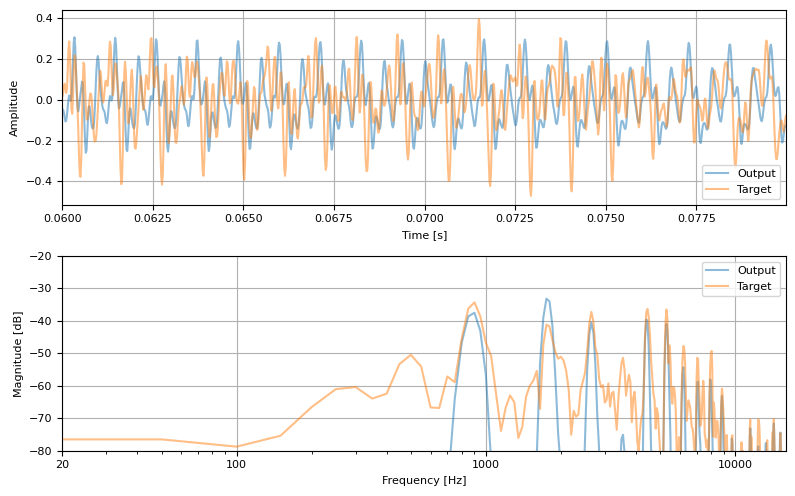

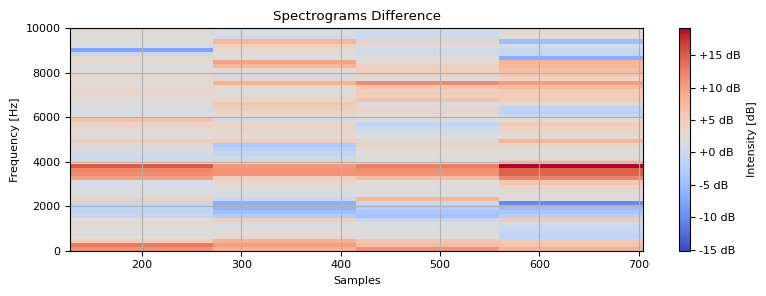

Processing pred-GRU-stft-48k.wav and target-GRU-stft-48k.wav


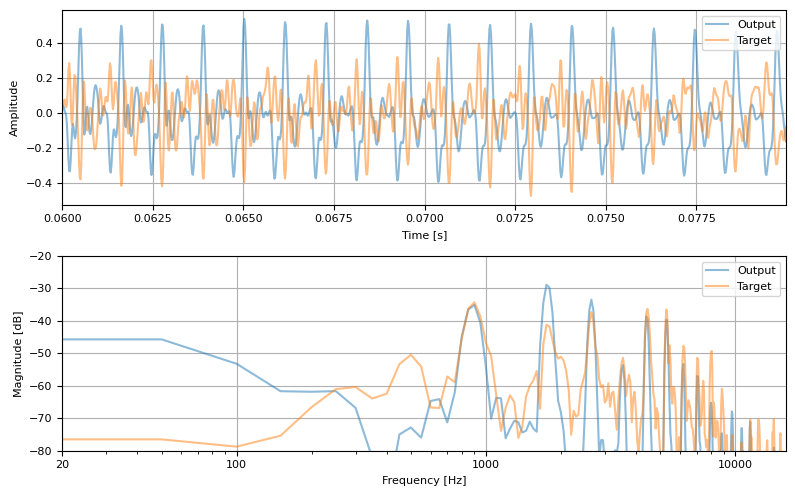

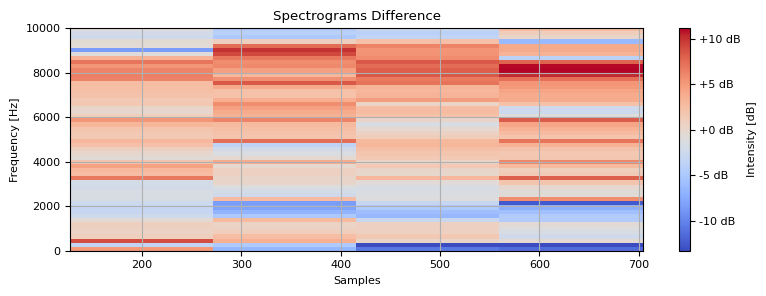

Processing pred-WaveNet-stft-48k.wav and target-WaveNet-stft-48k.wav


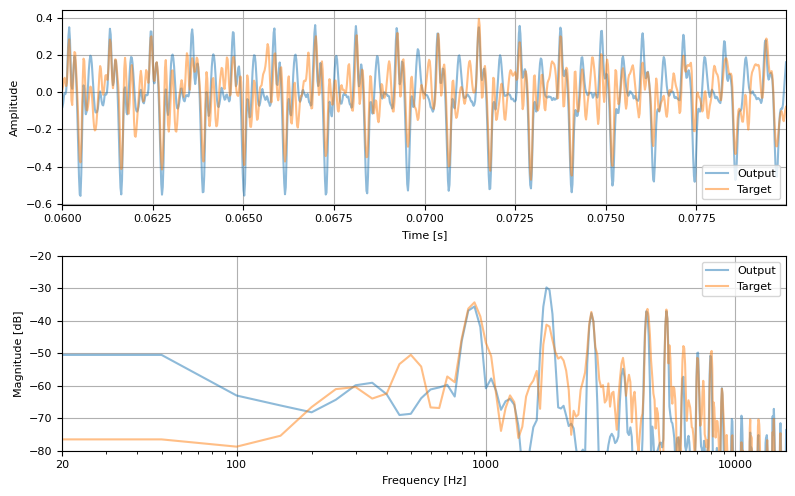

In [32]:
process_directory(EVAL_SAMPLES, start_idx, end_idx)